In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect

from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Visualize Measurment first set of data as a dictionary
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff7ebaf5cd0>,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08}

In [11]:
# Visualize Station first set of data as a dictionary
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff7ec9db810>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
# Convert Measurement into Pandas DataFrame
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [13]:
# Calculate the date 1 year ago from the last data point in the database
# Find the latest date in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [14]:
latest_date = dt.date(2017, 8 ,23)
a_year_ago = latest_date - dt.timedelta(days=365)
a_year_ago

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(a_year_ago, latest_date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp).set_index("date")

# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values("date")

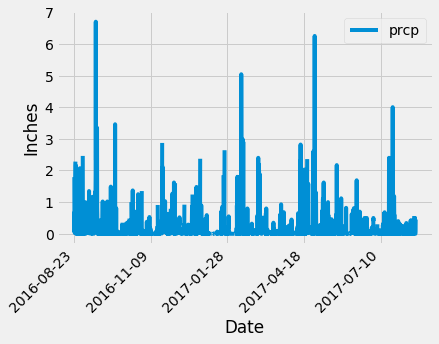

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df.plot(y = "prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation = "45", horizontalalignment = "right")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(distinct(Measurement.station)).count()
station_number

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
print(f"The most active station is {active_stations[0][0]}.")

The most active station is USC00519281.


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# The most active station is USC00519281.
lowest_tobs = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
highest_tobs = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
avg_tobs = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
print(f"The the lowest temperature is {lowest_tobs}, highest temperature is {highest_tobs}, and average temperature is {avg_tobs}.")

The the lowest temperature is 54.0, highest temperature is 85.0, and average temperature is 71.66378066378067.


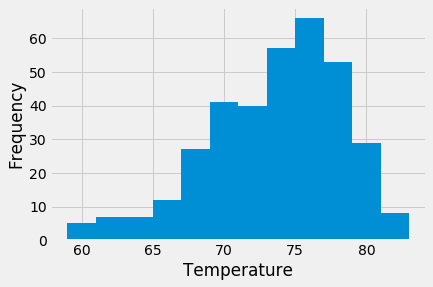

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between(a_year_ago, latest_date)).all()
date_tobs_df = pd.DataFrame(date_tobs).set_index("date")
plt.hist(date_tobs_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [23]:
# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [24]:
june_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).all()
june_temp_df = pd.DataFrame(june_temp, columns = ["station", "tavg_june"])
june_temp_df

,station,tavg_june
0,USC00511918,74.139394
1,USC00513117,74.050847
2,USC00514830,76.005376
3,USC00516128,71.937220
4,USC00517948,76.655405
5,USC00518838,73.394737
6,USC00519281,73.271186
7,USC00519397,77.559322
8,USC00519523,76.668103


In [25]:
dec_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).all()
dec_temp_df = pd.DataFrame(dec_temp, columns = ["station", "tavg_dec"])
dec_temp_df

,station,tavg_dec
0,USC00511918,69.684211
1,USC00513117,71.069444
2,USC00514830,73.224719
3,USC00516128,69.291262
4,USC00517948,71.834862
5,USC00518838,72.421053
6,USC00519281,69.903226
7,USC00519397,71.109524
8,USC00519523,72.433333


In [26]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
# I will use unpaired t-test because we are comparing the means of two independent samples (Jun vs. Dec).
from scipy.stats import ttest_ind
stat, p = ttest_ind(june_temp_df["tavg_june"], dec_temp_df["tavg_dec"])
print("t=%.3f, p=%.3f" % (stat, p))

t=4.616, p=0.000


### Therefore, the difference in the means of Jun vs Dec is statistically significant.

### Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# My trip is from 2017-03-01 to 2017-03-10
print(calc_temps("2017-03-01", "2017-03-10"))

[(62.0, 70.33870967741936, 78.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# A year ago
print(calc_temps("2016-03-01", "2016-03-10"))

[(62.0, 70.01515151515152, 78.0)]


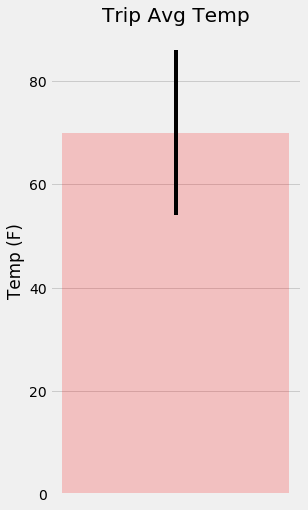

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_max = 78
temp_min = 62
temp_avg = 70.01515151515152
temp_dif = temp_max - temp_min

plt.figure(figsize=(4, 8))
plt.bar(1, temp_avg, yerr = temp_dif, color = "red", alpha = 0.2)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

### Daily Rainfall Average

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.date(2016, 3, 1)
end_date = dt.date(2016, 3, 10)
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.longitude, Station.latitude, Station.elevation]
rainfall = session.query(*sel).filter(Measurement.date.between(start_date, end_date)).\
            filter(Measurement.station == Station.station).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00519523',
  0.65,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5),
 ('USC00519281',
  0.36000000000000004,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00514830',
  0.29000000000000004,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00516128',
  0.21,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519397', 0.19, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0),
 ('USC00513117',
  0.16999999999999998,
  'KANEOHE 838.1, HI US',
  -157.8015,
  21.4234,
  14.6),
 ('USC00517948', None, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9)]

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = dt.date(2017, 3, 1)
end_date = dt.date(2017, 3, 10)

# Use the start and end date to create a range of dates
date_list = pd.date_range(start_date, end_date).tolist()

# Strip off the year and save a list of %m-%d strings
date_str_list = [date_list[i].strftime("%m-%d") for i in range(len(date_list))]

# Loop through the list of %m-%d strings and calculate the normals for each date
for i in range(len(date_str_list)):
    daily_normal = list(np.ravel(daily_normals(date_str_list[i])))
    normals.append(daily_normal)
normals

[[64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0],
 [60.0, 69.20338983050847, 76.0],
 [60.0, 69.17241379310344, 78.0],
 [59.0, 68.72413793103448, 78.0],
 [57.0, 68.56140350877193, 75.0],
 [57.0, 69.12280701754386, 75.0]]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
normals_df["date"] = date_list
normals_df.set_index("date", inplace = True)
normals_df

,tmin,tavg,tmax
date,,,
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0
2017-03-06,60.0,69.203390,76.0
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0


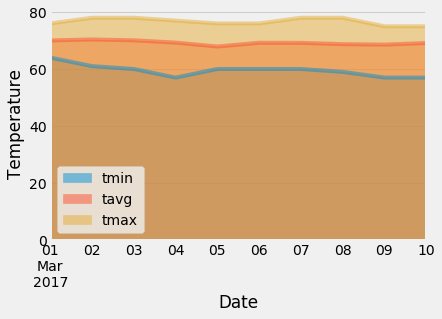

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked = False)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()